# Validation/test figures for all populations

Produce all validation/test figures for all populations in a single notebook.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, probplot
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [2]:
data_root = "../results/builds/simulated/simulated_sample_3"
data_root_full_tree = "../results/builds/simulated/simulated_sample_3_full_tree"
first_validation_timepoint = "2023-10-01"

min_clade_frequency = 0.15
precision = 4
pseudofrequency = 0.001
number_of_bootstrap_samples = 200

In [3]:
mpl.rcParams["figure.figsize"]

[6.0, 4.0]

In [4]:
sns.set_style("white")
plt.style.use("huddlej")

In [5]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18
mpl.rcParams['text.usetex'] = False

In [6]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["frequency_final"] > freq_df["frequency"])
        predicted_growth = (freq_df["projected_frequency"] > freq_df["frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["frequency_final"] < freq_df["frequency"])
        predicted_decline = (freq_df["projected_frequency"] < freq_df["frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [7]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [8]:
tips.head()

,strain,timepoint,frequency
0,sample_3236_14,2016-10-01,0.000013
1,sample_3236_17,2016-10-01,0.000013
2,sample_3236_19,2016-10-01,0.000013
3,sample_3236_21,2016-10-01,0.000013
4,sample_3236_22,2016-10-01,0.000013


In [9]:
first_validation_timepoint

'2023-10-01'

In [10]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [11]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root_full_tree, sep="\t",
                             usecols=["tip", "clade_membership", "depth"])

In [12]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [13]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "frequency", "projected_frequency"]
)

In [14]:
forecasts.head()

,timepoint,strain,frequency,projected_frequency
0,2016-10-01,sample_3236_14,0.000013,1.405414e-15
1,2016-10-01,sample_3236_17,0.000013,7.802684e-08
2,2016-10-01,sample_3236_19,0.000013,8.397902e-11
3,2016-10-01,sample_3236_21,0.000013,1.371248e-08
4,2016-10-01,sample_3236_22,0.000013,1.671481e-12


In [15]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [16]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

## Find large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [17]:
clade_tip_initial_frequencies = tips_to_clades.merge(
    tips,
    on=["strain"]
)

In [18]:
clade_tip_initial_frequencies["future_timepoint"] = clade_tip_initial_frequencies["timepoint"] + pd.DateOffset(months=12)

In [19]:
initial_clade_frequencies = clade_tip_initial_frequencies.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

Merge clade frequencies between adjacent years.

In [20]:
initial_and_observed_clade_frequencies = initial_clade_frequencies.merge(
    initial_clade_frequencies,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_final"]
).groupby(["timepoint", "clade_membership", "frequency"])["frequency_final"].sum().reset_index()

Select clades with an initial frequency above the defined threshold.

In [21]:
large_clades = initial_and_observed_clade_frequencies.query("frequency > %s" % min_clade_frequency).copy()

## Find estimated future frequencies of large clades

Use the true fitness metric for forecasts.

In [22]:
clade_tip_estimated_frequencies = tips_to_clades.merge(
    forecasts,
    on=["strain"]
)

In [23]:
estimated_clade_frequencies = clade_tip_estimated_frequencies.groupby(
    ["timepoint", "clade_membership"]
).aggregate({"projected_frequency": "sum"}).reset_index()

In [24]:
complete_clade_frequencies = large_clades.merge(
    estimated_clade_frequencies,
    on=["timepoint", "clade_membership"],
    suffixes=["", "_other"]
)

In [25]:
complete_clade_frequencies = np.round(complete_clade_frequencies, 2)

In [26]:
complete_clade_frequencies = complete_clade_frequencies.query("frequency != frequency_final").copy()

In [27]:
complete_clade_frequencies["observed_growth_rate"] = (
    complete_clade_frequencies["frequency_final"] / complete_clade_frequencies["frequency"]
)
complete_clade_frequencies["estimated_growth_rate"] = (
    complete_clade_frequencies["projected_frequency"] / complete_clade_frequencies["frequency"]
)

In [28]:
#complete_clade_frequencies["year"] = complete_clade_frequencies["timepoint"].dt.year

In [29]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(complete_clade_frequencies, True)
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])

In [30]:
complete_clade_frequencies["log_observed_growth_rate"] = (
    np.log10((complete_clade_frequencies["frequency_final"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

complete_clade_frequencies["log_estimated_growth_rate"] = (
    np.log10((complete_clade_frequencies["projected_frequency"] + pseudofrequency) / (complete_clade_frequencies["frequency"] + pseudofrequency))
)

In [31]:
upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())
log_lower_limit = complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(complete_clade_frequencies.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

In [32]:
r, p = pearsonr(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"]
)

## Inspect uncertainty in forecast accuracy

Use observed forecasting errors to inspect the accuracy of one-year lookaheads based on the initial frequency of each clade.

In [33]:
complete_clade_frequencies["clade_error"] = complete_clade_frequencies["frequency_final"] - complete_clade_frequencies["projected_frequency"]

In [34]:
complete_clade_frequencies["absolute_clade_error"] = np.abs(complete_clade_frequencies["clade_error"])

In [35]:
bootstrap_samples = []
for i in range(number_of_bootstrap_samples):
    complete_clade_frequencies_sample = complete_clade_frequencies.sample(frac=1.0, replace=True).copy()
    z = sm.nonparametric.lowess(
        complete_clade_frequencies_sample["absolute_clade_error"].values * 100,
        complete_clade_frequencies_sample["frequency"].values * 100
    )
    
    bootstrap_samples.append(
        pd.DataFrame({
            "initial_frequency": z[:, 0],
            "loess": z[:, 1]}
        )
    )

In [36]:
bootstrap_df = pd.concat(bootstrap_samples)

In [37]:
bootstrap_summary = bootstrap_df.groupby("initial_frequency")["loess"].agg(
    lower=lambda group: np.percentile(group, 2.5),
    mean=np.mean,
    upper=lambda group: np.percentile(group, 97.5)
).reset_index()

In [38]:
exogenous_frequency = bootstrap_summary["initial_frequency"].values

In [39]:
mean_lowess_fit = bootstrap_summary["mean"].values
upper_lowess_fit = bootstrap_summary["upper"].values
lower_lowess_fit = bootstrap_summary["lower"].values

## Estimated and observed closest strains per timepoint

In [40]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [41]:
sorted_df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
8820,2023-10-01,sample_4636_1,0.000013,6.303122,8.846077,14.429269,4.717925e-05,4.210202,2024-10-01
9236,2023-10-01,sample_4712_39,0.002323,5.657689,9.116452,4.757331,5.313585e-07,3.299014,2024-10-01
9237,2023-10-01,sample_4712_66,0.002323,6.586278,10.796369,4.198102,3.037508e-07,4.852093,2024-10-01
9238,2023-10-01,sample_4712_81,0.002323,7.768680,10.299197,1.165743,1.464134e-08,5.615084,2024-10-01
9239,2023-10-01,sample_4712_87,0.002323,7.789010,9.739459,1.977943,3.298485e-08,5.654458,2024-10-01


In [42]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [43]:
sorted_df["timepoint_estimated_rank"] = sorted_df.groupby("timepoint")["y"].rank(pct=True)

In [44]:
rank_rho, rank_p = spearmanr(
    sorted_df["timepoint_rank"],
    sorted_df["timepoint_estimated_rank"]
)

In [45]:
rank_rho

0.9381837649525753

In [46]:
rank_p

0.0

In [47]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "y"],
    ascending=True
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [48]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2023-10-01,0.170635
1,2024-04-01,0.027778
2,2024-10-01,0.103175
3,2025-04-01,0.183333
4,2025-10-01,0.019048


In [49]:
observed_closest_strains = sorted_df.sort_values(
    ["timepoint", "weighted_distance_to_future"],
    ascending=True
).groupby("timepoint").first().reset_index().loc[:, ["timepoint", "strain", "weighted_distance_to_future"]]

In [50]:
estimated_closest_strains = sorted_df.sort_values(
    ["timepoint", "y"],
    ascending=True
).groupby("timepoint").first().reset_index().loc[:, ["timepoint", "strain", "y", "timepoint_rank"]]

In [51]:
estimated_closest_strains.head()

,timepoint,strain,y,timepoint_rank
0,2023-10-01,sample_4704_81,2.308957,0.170635
1,2024-04-01,sample_4788_82,3.237261,0.027778
2,2024-10-01,sample_4924_21,2.607134,0.103175
3,2025-04-01,sample_4936_55,3.906650,0.183333
4,2025-10-01,sample_5112_84,1.765343,0.019048


In [52]:
tips_with_sequence = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "aa_sequence"]
)

In [53]:
tips_with_sequence.head()

,strain,aa_sequence,timepoint
0,sample_3236_14,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,2016-10-01
1,sample_3236_17,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,2016-10-01
2,sample_3236_19,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,2016-10-01
3,sample_3236_21,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,2016-10-01
4,sample_3236_22,MKTIIALSYILCLVFAQKLLGNDNSTATLCLGHHSVPNGTLVKTIS...,2016-10-01


In [54]:
tips_with_sequence.shape

(30870, 3)

In [55]:
distinct_tips_with_sequence = tips_with_sequence.groupby(["timepoint", "aa_sequence"]).first().reset_index()

In [56]:
distinct_tips_with_sequence.head()

,timepoint,aa_sequence,strain
0,2016-10-01,IKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHLVPNGTLVKTIS...,sample_3312_3
1,2016-10-01,IKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,sample_3260_90
2,2016-10-01,MKTIIALRYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,sample_3248_78
3,2016-10-01,MKTIIALSYILCLFFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,sample_3288_2
4,2016-10-01,MKTIIALSYILCLVFAEKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,sample_3268_36


In [57]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [58]:
sorted_df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
8820,2023-10-01,sample_4636_1,0.000013,6.303122,8.846077,14.429269,4.717925e-05,4.210202,2024-10-01
9236,2023-10-01,sample_4712_39,0.002323,5.657689,9.116452,4.757331,5.313585e-07,3.299014,2024-10-01
9237,2023-10-01,sample_4712_66,0.002323,6.586278,10.796369,4.198102,3.037508e-07,4.852093,2024-10-01
9238,2023-10-01,sample_4712_81,0.002323,7.768680,10.299197,1.165743,1.464134e-08,5.615084,2024-10-01
9239,2023-10-01,sample_4712_87,0.002323,7.789010,9.739459,1.977943,3.298485e-08,5.654458,2024-10-01


In [59]:
sorted_df.shape

(20790, 9)

In [60]:
sorted_df = sorted_df.merge(
    distinct_tips_with_sequence,
    on=["timepoint", "strain"]
)

In [61]:
sorted_df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint,aa_sequence
0,2023-10-01,sample_4636_1,0.000013,6.303122,8.846077,14.429269,4.717925e-05,4.210202,2024-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
1,2023-10-01,sample_4712_39,0.002323,5.657689,9.116452,4.757331,5.313585e-07,3.299014,2024-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
2,2023-10-01,sample_4712_66,0.002323,6.586278,10.796369,4.198102,3.037508e-07,4.852093,2024-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHSVPNGTLVKTIS...
3,2023-10-01,sample_4712_81,0.002323,7.768680,10.299197,1.165743,1.464134e-08,5.615084,2024-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
4,2023-10-01,sample_4712_87,0.002323,7.789010,9.739459,1.977943,3.298485e-08,5.654458,2024-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...


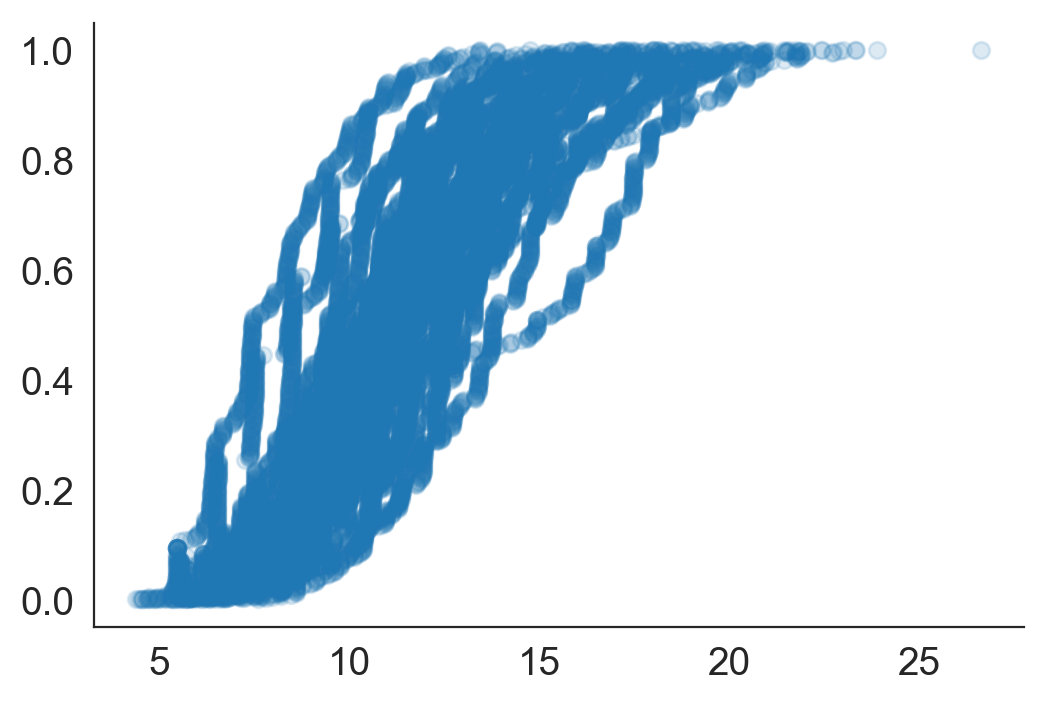

In [62]:
plt.plot(
    sorted_df["weighted_distance_to_future"],
    sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True),
    "o",
    alpha=0.15
)

In [63]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)
sorted_df["timepoint_estimated_rank"] = sorted_df.groupby("timepoint")["y"].rank(pct=True)

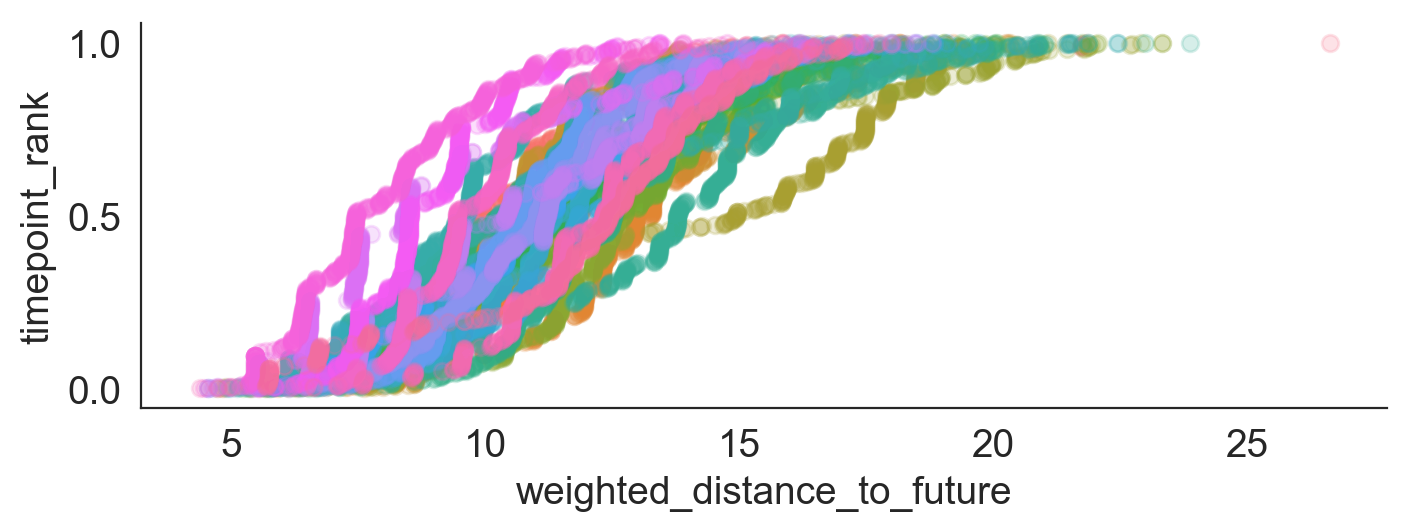

In [64]:
g = sns.FacetGrid(sorted_df, hue="timepoint", aspect=2.5)
g.map(plt.scatter, "weighted_distance_to_future", "timepoint_rank", alpha=0.2)

In [65]:
sorted_df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint,aa_sequence,timepoint_rank,timepoint_estimated_rank
0,2023-10-01,sample_4636_1,0.000013,6.303122,8.846077,14.429269,4.717925e-05,4.210202,2024-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,0.230612,0.144898
1,2023-10-01,sample_4712_39,0.002323,5.657689,9.116452,4.757331,5.313585e-07,3.299014,2024-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,0.240816,0.022449
2,2023-10-01,sample_4712_66,0.002323,6.586278,10.796369,4.198102,3.037508e-07,4.852093,2024-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHSVPNGTLVKTIS...,0.606122,0.340816
3,2023-10-01,sample_4712_81,0.002323,7.768680,10.299197,1.165743,1.464134e-08,5.615084,2024-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,0.500000,0.440816
4,2023-10-01,sample_4712_87,0.002323,7.789010,9.739459,1.977943,3.298485e-08,5.654458,2024-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,0.322449,0.461224


In [66]:
spearmanr(
    sorted_df["timepoint_rank"],
    sorted_df["timepoint_estimated_rank"]
)

SpearmanrResult(correlation=0.9334985092664977, pvalue=0.0)

In [67]:
observed_closest_strains = observed_closest_strains.merge(
    tips_with_sequence,
    on=["timepoint", "strain"]
)

In [68]:
estimated_closest_strains = estimated_closest_strains.merge(
    tips_with_sequence,
    on=["timepoint", "strain"]
)

In [69]:
estimated_closest_strains.head()

,timepoint,strain,y,timepoint_rank,aa_sequence
0,2023-10-01,sample_4704_81,2.308957,0.170635,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
1,2024-04-01,sample_4788_82,3.237261,0.027778,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
2,2024-10-01,sample_4924_21,2.607134,0.103175,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
3,2025-04-01,sample_4936_55,3.906650,0.183333,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
4,2025-10-01,sample_5112_84,1.765343,0.019048,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNSTLVKTIS...


In [70]:
closest_strains = observed_closest_strains.merge(
    estimated_closest_strains,
    on=["timepoint"],
    suffixes=["_observed", "_estimated"]
)

In [71]:
closest_strains.head()

,timepoint,strain_observed,weighted_distance_to_future,aa_sequence_observed,strain_estimated,y,timepoint_rank,aa_sequence_estimated
0,2023-10-01,sample_4736_96,4.857050,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,sample_4704_81,2.308957,0.170635,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
1,2024-04-01,sample_4820_78,5.541482,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...,sample_4788_82,3.237261,0.027778,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
2,2024-10-01,sample_4944_40,5.917776,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNSTLVKTIS...,sample_4924_21,2.607134,0.103175,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
3,2025-04-01,sample_5048_7,5.392066,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNSTLVKTIS...,sample_4936_55,3.906650,0.183333,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNGTLVKTIS...
4,2025-10-01,sample_5120_36,5.690176,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNSTLVKTIS...,sample_5112_84,1.765343,0.019048,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHSVPNSTLVKTIS...


In [72]:
closest_strains["aa_sequence_distance"] = closest_strains.apply(lambda row: (
    np.frombuffer(row["aa_sequence_observed"].encode(), dtype="S1") !=
    np.frombuffer(row["aa_sequence_estimated"].encode(), dtype="S1")
).sum(), axis=1)

In [73]:
closest_strains["aa_sequence_distance"].value_counts()

0    11
2     5
6     4
3     4
5     3
4     3
1     3
Name: aa_sequence_distance, dtype: int64

Text(0,0.5,'Number of timepoints')

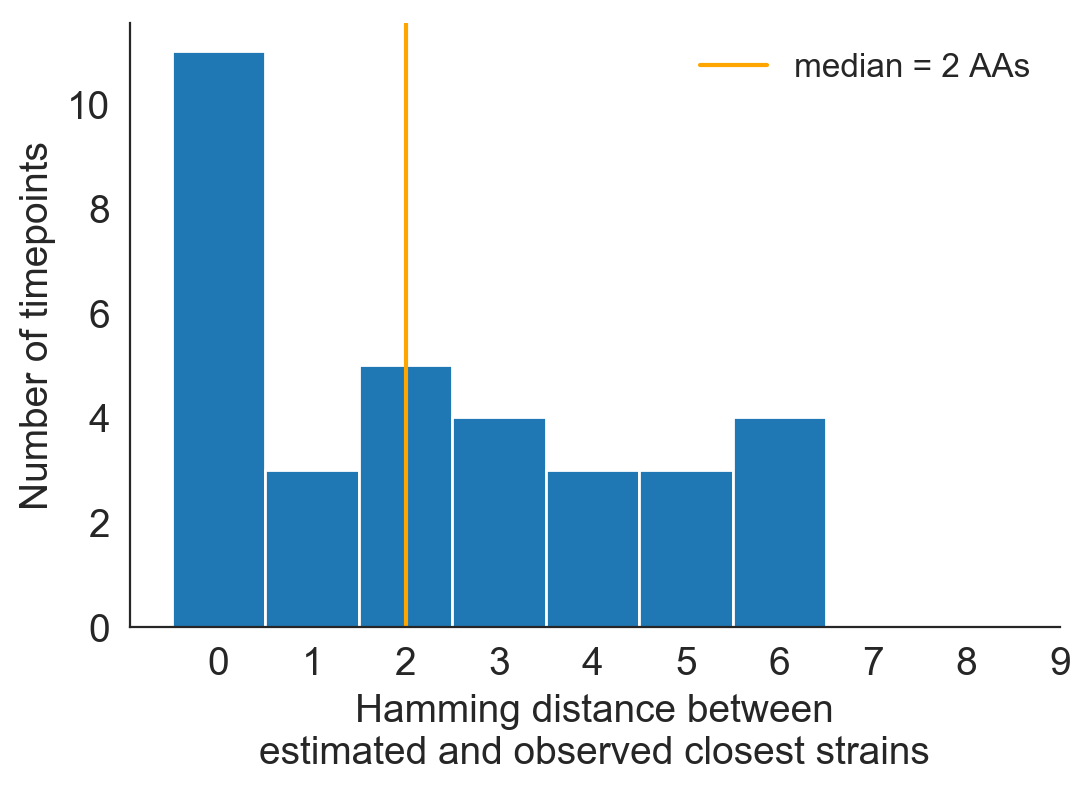

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

median_best_rank = closest_strains["aa_sequence_distance"].median()

bins = np.arange(0, 10, 1)
ax.hist(closest_strains["aa_sequence_distance"], bins=bins, label=None, align="left")
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i AAs" % median_best_rank
)
ax.set_xticks(bins)
#ax.set_xlim(0, 10)

ax.legend(
    frameon=False
)
ax.set_xlabel("Hamming distance between\nestimated and observed closest strains")
ax.set_ylabel("Number of timepoints")

Text(0,0.5,'Hamming distance between\nestimated and observed closest strains')

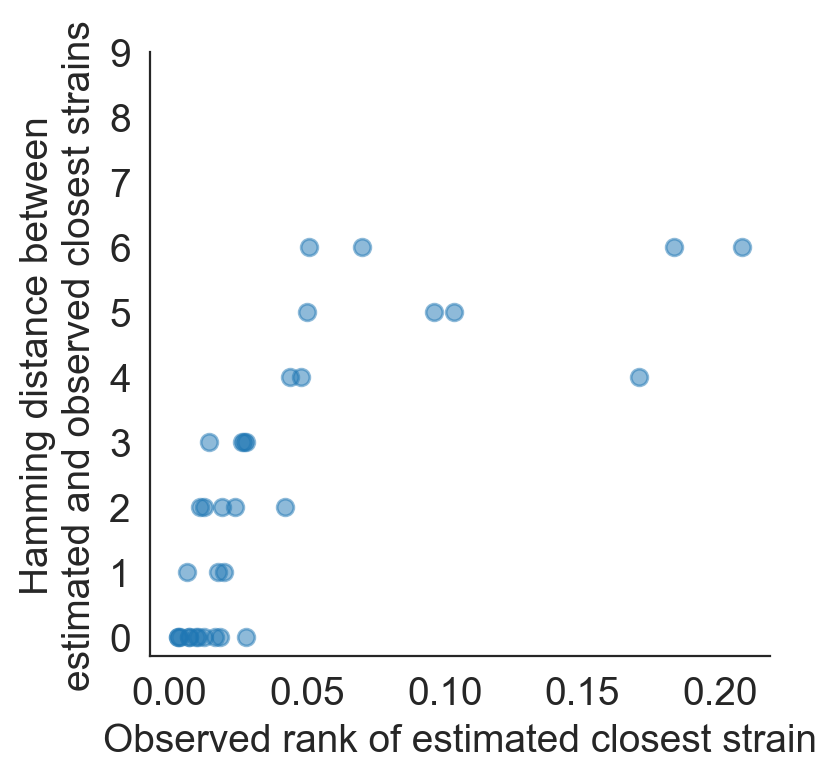

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(
    closest_strains["timepoint_rank"],
    closest_strains["aa_sequence_distance"],
    "o",
    alpha=0.5
)
ax.set_yticks(bins)
#ax.set_ylim(0, 10)

ax.set_xlabel("Observed rank of estimated closest strain")
ax.set_ylabel("Hamming distance between\nestimated and observed closest strains")

In [76]:
sorted(closest_strains.loc[closest_strains["aa_sequence_distance"] == 0, "timepoint_rank"].values)

[0.0031746031746031746,
 0.0031746031746031746,
 0.003968253968253968,
 0.007142857142857143,
 0.007142857142857143,
 0.009523809523809525,
 0.010317460317460317,
 0.012698412698412698,
 0.016666666666666666,
 0.018253968253968255,
 0.027777777777777776]

In [77]:
sorted(closest_strains.loc[closest_strains["aa_sequence_distance"] == 6, "timepoint_rank"].values)

[0.050793650793650794,
 0.06984126984126984,
 0.18333333333333332,
 0.20793650793650795]

## Merge validation figures into subpanels of one figure

Required variables:

 - `complete_clade_frequencies`
 - `p` and `r`
 - `best_fitness_rank_by_timepoint_df`
 - `exogenous_frequency`, `lower_lowess_fit`, `upper_lowess_fit`, and `mean_lowess_fit`
 - `rank_p` and `rank_rho`
 - `sorted_df`

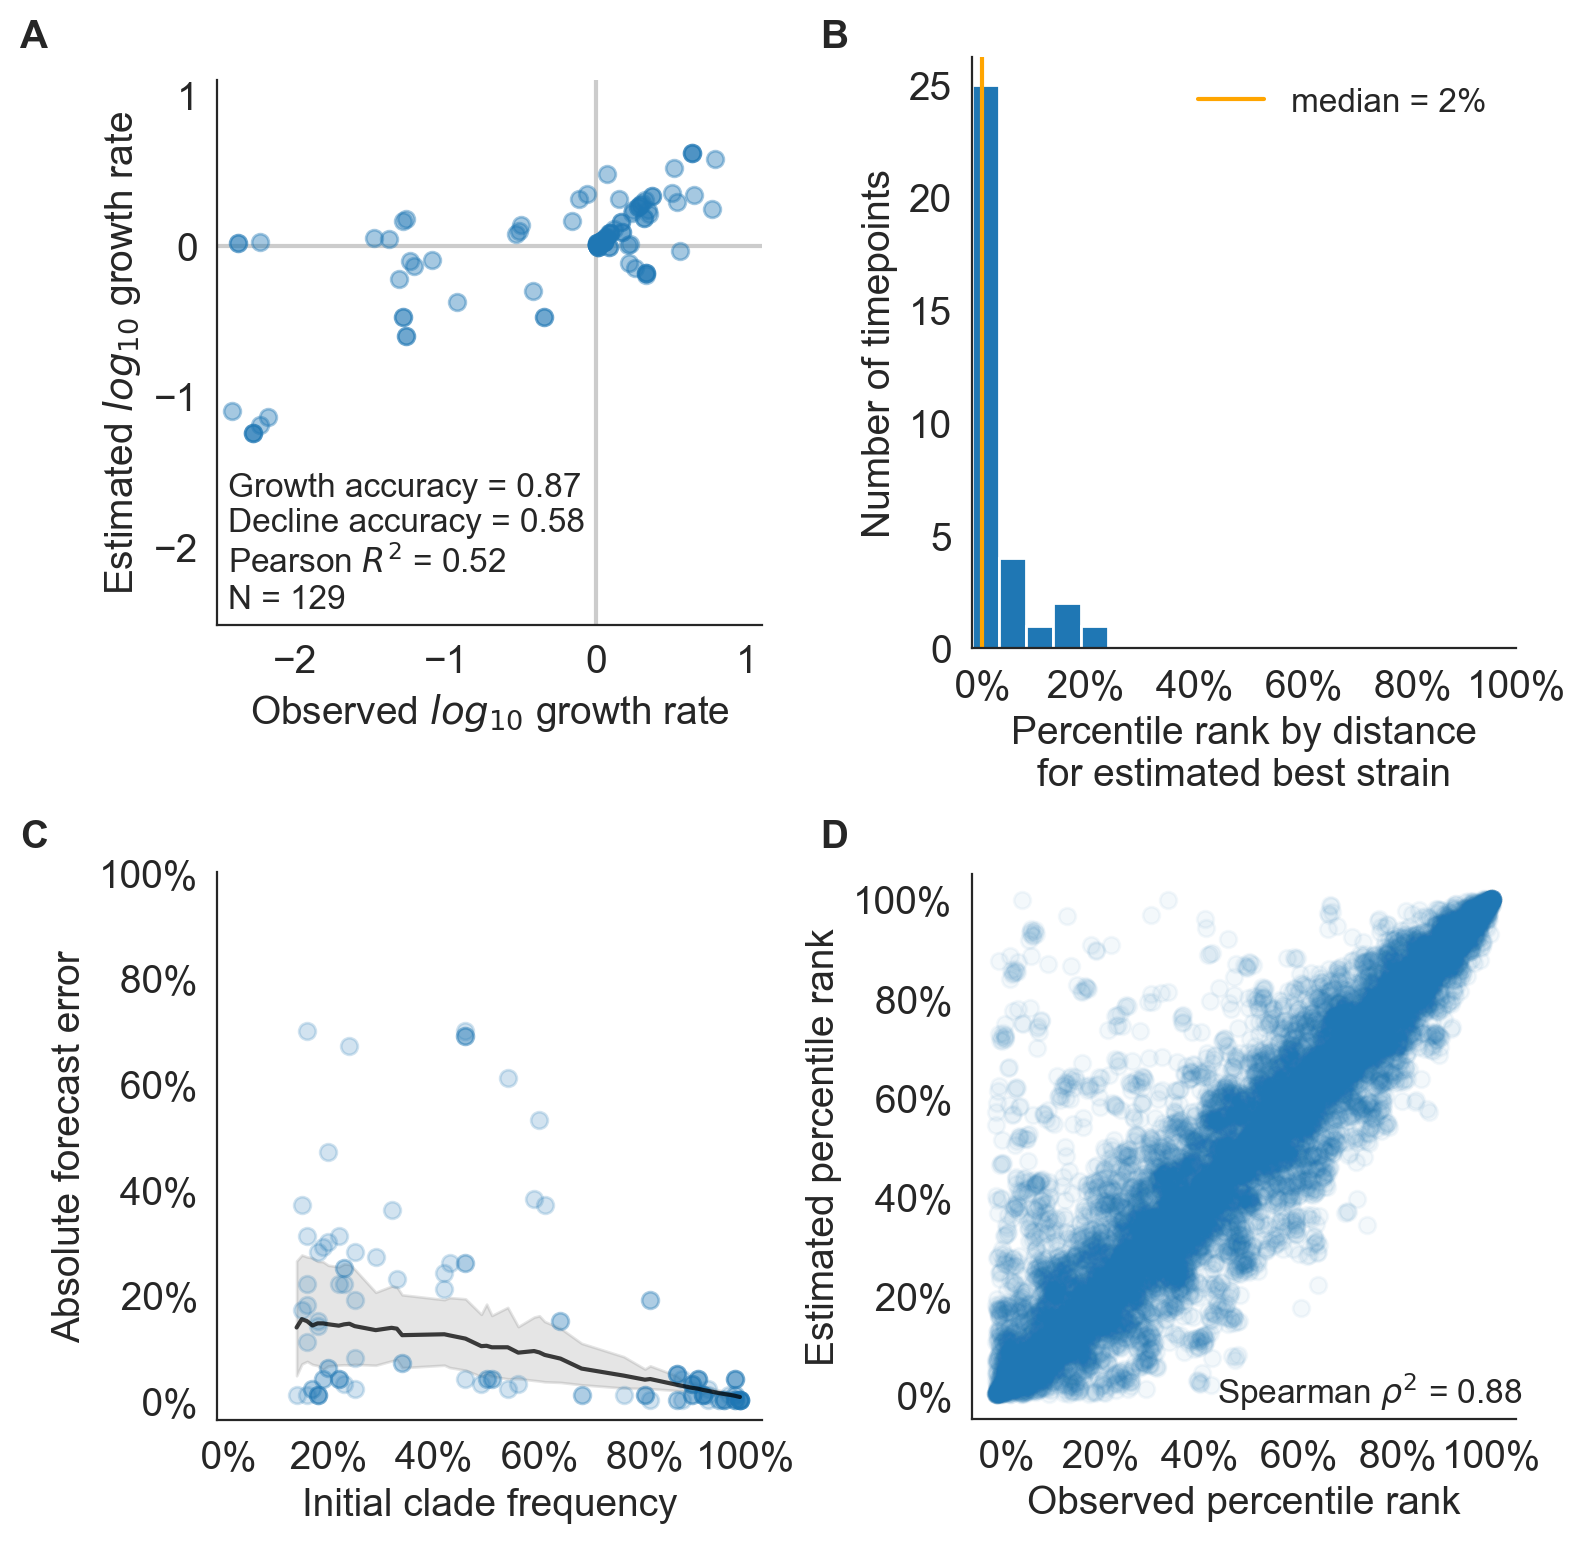

In [86]:
fig = plt.figure(figsize=(8, 8), facecolor='w')
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.1)

ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    complete_clade_frequencies["log_observed_growth_rate"],
    complete_clade_frequencies["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p value$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.15,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\nPearson $R^2$ = %.2f\nN = %s" % (
        growth_accuracy,
        decline_accuracy,
        r ** 2,
        complete_clade_frequencies.shape[0]
    ),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

growth_rate_ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(growth_rate_ticks)
clade_ax.set_yticks(growth_rate_ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticks(ticks)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in ticks])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

#
# Absolute clade forecast errors with uncertainty.
#
forecast_error_ax = fig.add_subplot(gs[2])
forecast_error_ax.plot(
    complete_clade_frequencies["frequency"].values * 100,
    complete_clade_frequencies["absolute_clade_error"].values * 100,
    "o",
    alpha=0.2
)

forecast_error_ax.fill_between(
    exogenous_frequency,
    lower_lowess_fit,
    upper_lowess_fit,
    alpha=0.1,
    color="black"
)
forecast_error_ax.plot(
    exogenous_frequency,
    mean_lowess_fit,
    alpha=0.75,
    color="black"
)

forecast_error_ax.set_xlabel("Initial clade frequency")
forecast_error_ax.set_ylabel("Absolute forecast error")

forecast_error_ax.set_xticks(ticks * 100)
forecast_error_ax.set_yticks(ticks * 100)
forecast_error_ax.set_xticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])
forecast_error_ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])

forecast_error_ax.set_aspect("equal")

#
# Observed vs. estimated percentile rank for all strains at all timepoints.
#

all_rank_ax = fig.add_subplot(gs[3])

if rank_p < 0.001:
    rank_p_value = "$p$ < 0.001"
else:
    rank_p_value = "$p$ = %.3f" % rank_p

all_rank_ax.plot(
    sorted_df["timepoint_rank"],
    sorted_df["timepoint_estimated_rank"],
    "o",
    alpha=0.05
)

all_rank_ax.text(
    0.45,
    0.05,
    "Spearman $\\rho^2$ = %.2f" % (rank_rho ** 2,),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=all_rank_ax.transAxes
)

all_rank_ax.set_xticks(ticks)
all_rank_ax.set_yticks(ticks)
all_rank_ax.set_xticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])
all_rank_ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in ticks])

all_rank_ax.set_xlabel("Observed percentile rank")
all_rank_ax.set_ylabel("Estimated percentile rank")
all_rank_ax.set_aspect("equal")

# Annotate panel labels.
panel_labels_dict = {
    "weight": "bold",
    "size": 14
}
plt.figtext(0.0, 0.97, "A", **panel_labels_dict)
plt.figtext(0.5, 0.97, "B", **panel_labels_dict)
plt.figtext(0.0, 0.47, "C", **panel_labels_dict)
plt.figtext(0.5, 0.47, "D", **panel_labels_dict)

gs.tight_layout(fig)
#plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations.pdf")

In [79]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum()

32

In [80]:
best_fitness_rank_by_timepoint_df.shape

(33, 2)

In [81]:
(best_fitness_rank_by_timepoint_df["timepoint_rank"] <= 0.2).sum() / float(best_fitness_rank_by_timepoint_df.shape[0])

0.9696969696969697